In [ ]:
# Lets look at the overlap between SST and MSIT tasks

In [1]:
import os 
import shutil, sys 
import json
import glob
import nibabel as nib
import nilearn
from nilearn import plotting, image
from nilearn.image import math_img
import re
import pandas as pd
import pydicom, ntpath
import numpy as np
from scipy import ndimage

import subprocess
from os.path import join as opj
from pathlib import Path
import operator
import itertools
import joblib
from nilearn.glm.second_level import SecondLevelModel

import multiprocessing as mp
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
%matplotlib inline
from plotting_utils import *

import nipype
import nipype.interfaces.io as nio
import nipype.interfaces.fsl as fsl
import nipype.interfaces.ants as ants
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
import nipype.algorithms.modelgen as model

220707-11:05:00,493 nipype.utils WARNING:
	 A newer version (1.8.1) of nipy/nipype is available. You are using 1.7.0


In [2]:
## conjunction analysis
def conj_math_min(map1, map2): # nimares implementation, allows neg
    
    formula = "np.where(img * img2 > 0, np.minimum(img, img2), 0)"
    img_conj = math_img(formula, img=map1, img2=map2)
    
    return img_conj

def conj_math_max(map1, map2): # nimares implementation, allows neg
    
    formula = "np.where(img * img2 > 0, np.maximum(img, img2), 0)"
    img_conj = math_img(formula, img=map1, img2=map2)
    
    return img_conj

def conj_map_sum(map1, map2):
    
    formula = "np.divide(np.sum(img, img2), 2)"
    img_conj = math_img(formula, img=map1, img2=map2)
    
    return img_conj

def conj_map_multiply(map1, map2):
    
    formula = "np.sqrt(np.multiply(img, img2))"
    img_conj = math_img(formula, img=map1, img2=map2)
    
    return img_conj

# def conj_math(map1, map2): # other implementation, pos only
    
#     img_conj = nli.math_img('np.minimum(img1*(img1>0), img2*(img2>0)) + ' + \
#                          'np.maximum(img1*(img1<0), img2*(img2<0))', 
#                          img1=map1, 
#                          img2=map2)
    
#     return img_conj

# if you wanna use feat GLMS
def conj_feat_stat_maps(msit_con_n, sst_con_n, cmethod='min', ses='sstmsit',fwhm='1p5',to_plot=False):
    
    glms_msit = sorted(glob.glob(f'../derivatives/glm_feat/subject_level_model/sub-*/ses-{ses}/func/fwhm-{fwhm}/model-0/sub-*_ses-{ses}_task-msit_space-T1w_model-0_contrast-{msit_con_n}_desc-zstat.nii.gz'))
    glms_sst = sorted(glob.glob(f'../derivatives/glm_feat/subject_level_model/sub-*/ses-{ses}/func/fwhm-{fwhm}/model-0/sub-*_ses-{ses}_task-sst_space-T1w_model-0_contrast-{sst_con_n}_desc-zstat.nii.gz'))
    
    for msit_map, sst_map in zip(glms_msit, glms_sst):
        
        sub = sub_sst = sst_map.split('/')[4].split('-')[1]
        sub_msit = msit_map.split('/')[4].split('-')[1]
        if cmethod == 'min':
            img_conj = conj_math_min(msit_map, sst_map)
        elif cmethod == 'max':
            img_conj = conj_math_max(msit_map, sst_map)
        elif cmethod == 'sum':
            img_conj = conj_math_sum(msit_map, sst_map)
        elif cmethod == 'multiply':
            img_conj = conj_math_multiply(msit_map, sst_map)
        
        print('sst: ' + sub_sst)
        print('msit: ' + sub_msit)
        
        if sub_sst == sub_msit:
            output_fn = f'../derivatives/conjunction_analyses/sub-{sub}/ses-{ses}/feat/{cmethod}/fwhm-{fwhm}/sub-{sub}_ses-{ses}_conj_msitcontrast-{msit_con_n}_sstcontrast-{sst_con_n}_zmap.nii.gz'
            if not os.path.exists(os.path.dirname(output_fn)):
                os.makedirs(os.path.dirname(output_fn), exist_ok=True)

            img_conj.to_filename(output_fn)
            print(output_fn)
            if to_plot:
                plotting.plot_stat_map(img_conj)
        
    return

# if you wanna use nilearn glms
def conj_nilearn_stat_maps(msit_con, sst_con,fwhm='1p5', cmethod='min', ses='sstmsit', to_plot=False):
    
    glms_msit = sorted(glob.glob(f'../derivatives/glm_nilearn/subject_level_model/sub-*/ses-{ses}/func/fwhm-{fwhm}/model-0/sub-*_ses-sstmsit_task-msit_space-MNI152NLin2009cAsym_desc-contrast-{msit_con}_effect_size.nii.gz'))
    glms_sst = sorted(glob.glob(f'../derivatives/glm_nilearn/subject_level_model/sub-*/ses-{ses}/func/fwhm-{fwhm}/model-0/sub-*_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_desc-contrast-{sst_con}_effect_size.nii.gz'))
    for msit_map, sst_map in zip(glms_msit, glms_sst):
        
        sub = sub_sst = sst_map.split('/')[4].split('-')[1]
        sub_msit = msit_map.split('/')[4].split('-')[1]
        if cmethod == 'min':
            img_conj = conj_math_min(msit_map, sst_map)
        elif cmethod == 'max':
            img_conj = conj_math_max(msit_map, sst_map)
        elif cmethod == 'sum':
            img_conj = conj_math_sum(msit_map, sst_map)
        elif cmethod == 'multiply':
            img_conj = conj_math_multiply(msit_map, sst_map)
        
        print('sst: ' + sub_sst)
        print('msit: ' + sub_msit)
        
        if sub_sst == sub_msit:
            output_fn = f'../derivatives/conjunction_analyses/sub-{sub}/ses-{ses}/nilearn/{cmethod}/fwhm-{fwhm}/sub-{sub}_ses-{ses}_conj_msitcontrast-{msit_con}_sstcontrast-{sst_con}_effect_size.nii.gz'
            if not os.path.exists(os.path.dirname(output_fn)):
                os.makedirs(os.path.dirname(output_fn), exist_ok=True)

            img_conj.to_filename(output_fn)
            print(output_fn)
            if to_plot:
                plotting.plot_stat_map(img_conj)
        
    return

### contrast maps
#### MSIT

'con': 0,'simon': 1,'flanker': 2,'inc': 3,'simon-con': 4,'flanker-con': 5,'inc-con': 6,'simon-flanker': 7,'inc-simon': 8,'inc-flanker': 9,'timing_feedback': 10
#### SST

'fs': 0,'ss': 1,'go': 2,'fs-go': 3,'fs-ss': 4,'ss-go': 5

sst: 002
msit: 002
../derivatives/conjunction_analyses/sub-002/ses-sstmsit/nilearn/nimare/fwhm-4p5/sub-002_ses-sstmsit_conj_msitcontrast-Inc-Con_sstcontrast-fs-go_effect_size.nii.gz
sst: 003
msit: 003
../derivatives/conjunction_analyses/sub-003/ses-sstmsit/nilearn/nimare/fwhm-4p5/sub-003_ses-sstmsit_conj_msitcontrast-Inc-Con_sstcontrast-fs-go_effect_size.nii.gz
sst: 004
msit: 004
../derivatives/conjunction_analyses/sub-004/ses-sstmsit/nilearn/nimare/fwhm-4p5/sub-004_ses-sstmsit_conj_msitcontrast-Inc-Con_sstcontrast-fs-go_effect_size.nii.gz
sst: 005
msit: 005
../derivatives/conjunction_analyses/sub-005/ses-sstmsit/nilearn/nimare/fwhm-4p5/sub-005_ses-sstmsit_conj_msitcontrast-Inc-Con_sstcontrast-fs-go_effect_size.nii.gz
sst: 006
msit: 006
../derivatives/conjunction_analyses/sub-006/ses-sstmsit/nilearn/nimare/fwhm-4p5/sub-006_ses-sstmsit_conj_msitcontrast-Inc-Con_sstcontrast-fs-go_effect_size.nii.gz
sst: 007
msit: 007
../derivatives/conjunction_analyses/sub-007/ses-sstmsit/nilearn/nimare/

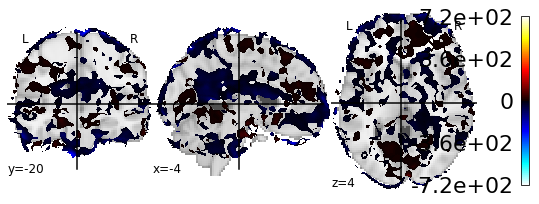

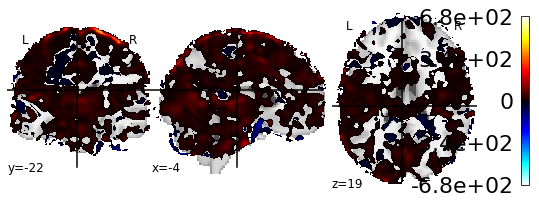

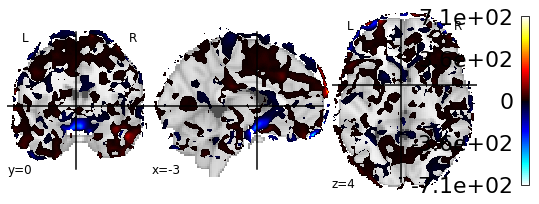

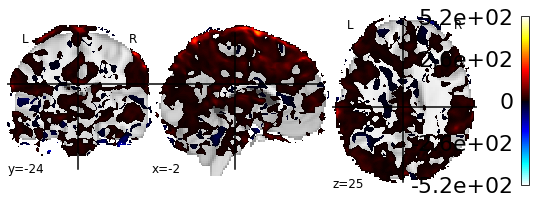

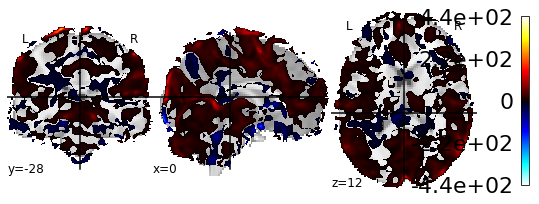

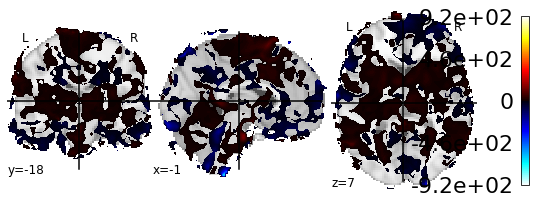

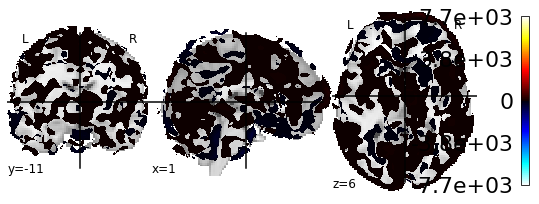

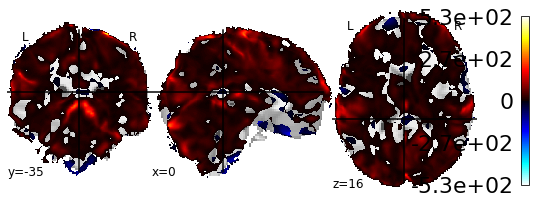

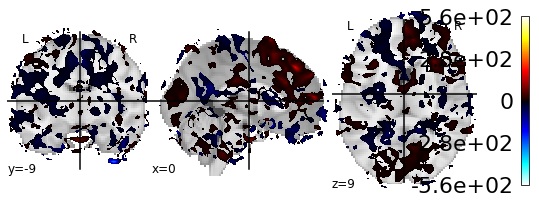

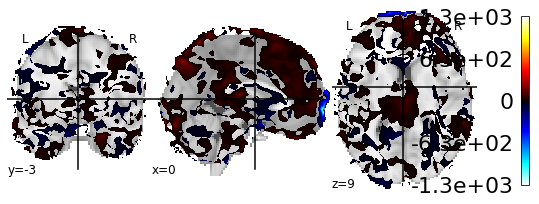

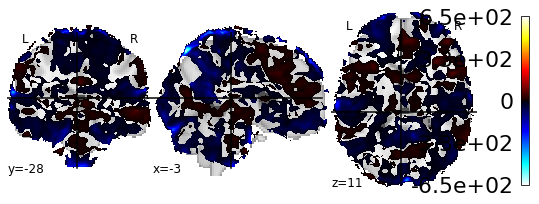

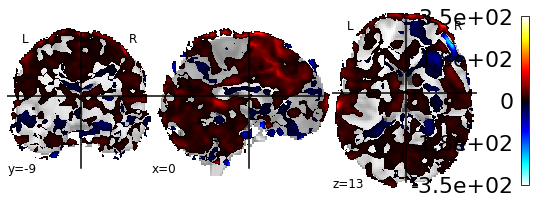

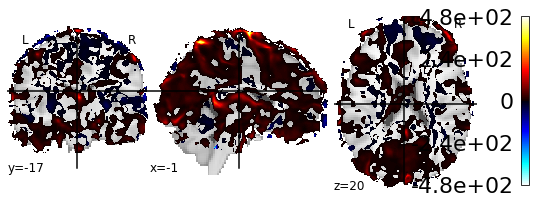

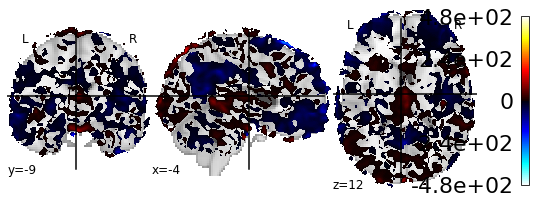

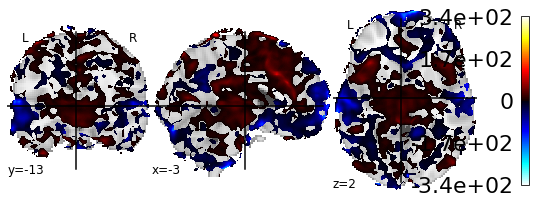

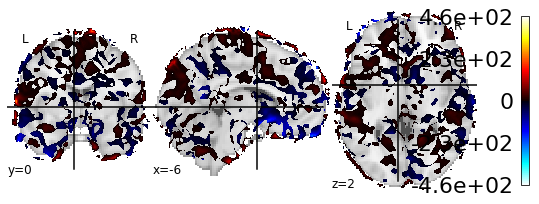

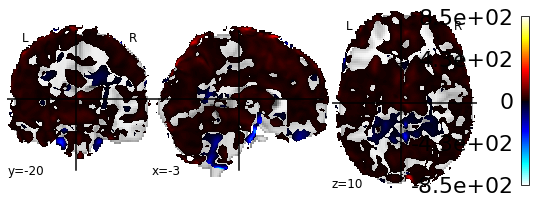

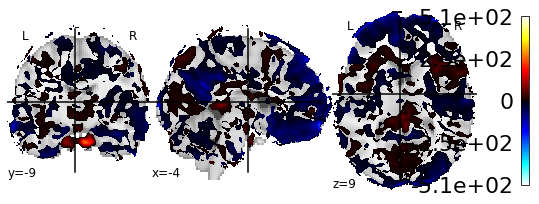

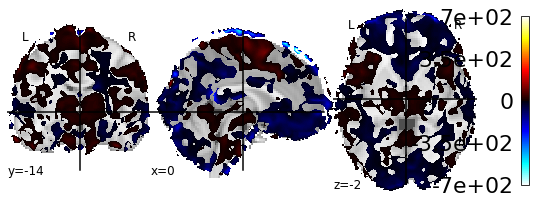

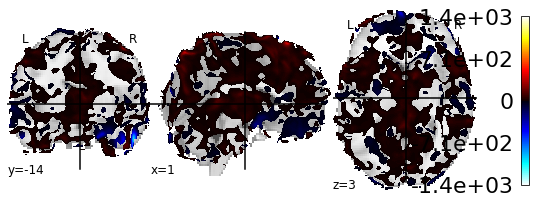

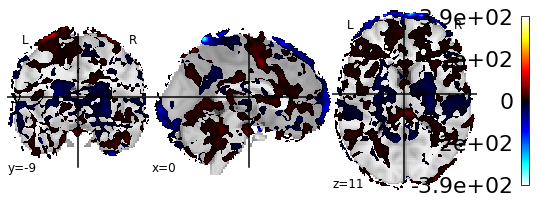

In [249]:
# make the conjunction maps of effect size nilearn GLM outputs
# conjunct = conj_feat_stat_maps(6, 3)
conjunct = conj_nilearn_stat_maps('Inc-Con','fs-go', fwhm='4p5')

# RUN GROUP ANALYSIS ON CONJUNCTIPPN STAT MAPS

## 1: NILEARN, simple conjunction - not taking SE into account

# What if i just take the conjunction of the group level stat maps?

Then we would be bad scientists, but still, lets just have a look...

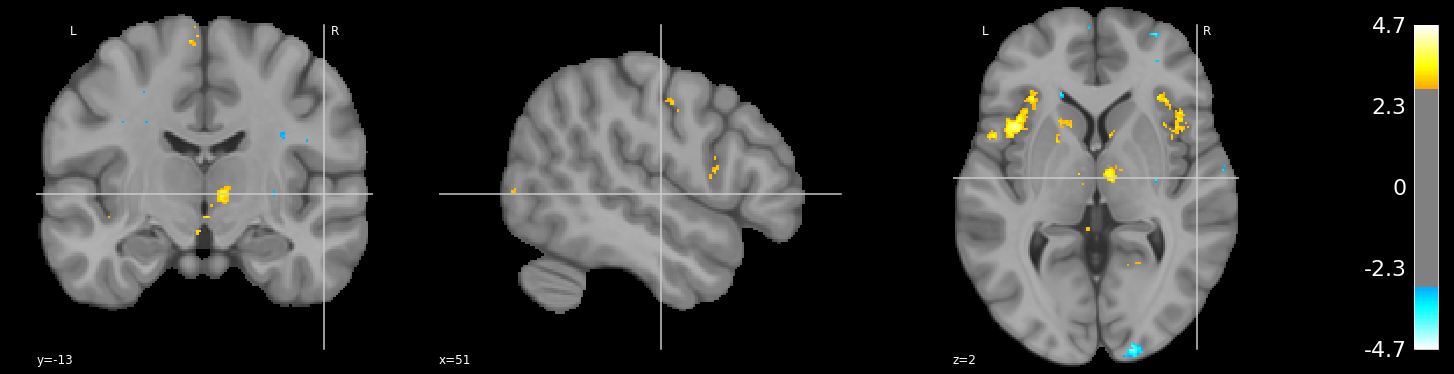

In [238]:
msit = '/home/Public/trondheim/derivatives/glm_feat/group_level_model/ses-sstmsit/task-msit/third_level_model/level3_zstats/_contrast_n_6_fwhm_1p5_model_n_0/zstat1.nii.gz'
sst = '/home/Public/trondheim/derivatives/glm_feat/group_level_model/ses-sstmsit/task-sst/third_level_model/level3_zstats/_contrast_n_3_fwhm_1p5_model_n_0/zstat1.nii.gz'

conjy = conj_math_nimare(msit,sst)
plotting.plot_stat_map(conjy, threshold=2.9, bg_img='/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii',cut_coords=(51,-13,2))
plt.gcf().set_size_inches(20,5)

# conjy.to_filename('/home/scotti/temp_conj.nii.gz')

/home/scotti/.conda/envs/py38/lib/python3.8/site-packages/nilearn/plotting/displays.py:97: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Text(0.5, 1.0, 'z-value')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


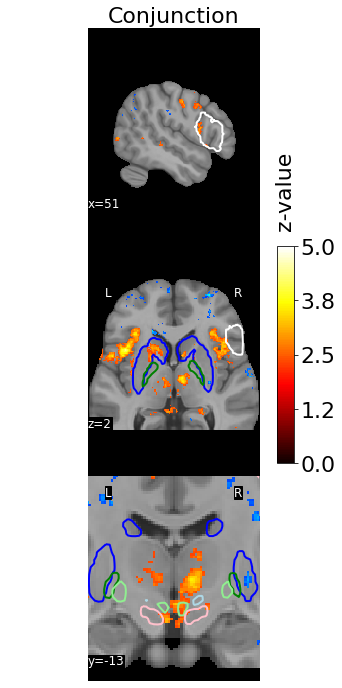

In [193]:
zmaps = ['/home/scotti/temp_conj.nii.gz']
mni09c = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

# plot t maps for smoothed images
fontsize = 22
vmax = 5
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, roi_dict=get_roi_dict(),z_threshold=2.3,f=f, axes=axes,roi_to_plot=['rIFG', 'STR', 'STN'],cut_coords=[[51], [2], [-13]],bg_img=mni09c,vmax=vmax, plot_columns=(0, 1, 2),annotate=True, empty_plots=False, skip_all_but_last=False)
axes[0,0].set_title('Conjunction')

for row in range(axes.shape[0]):
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# Cool, now lets do it properly: nilearn second level model

In [250]:
def save_second_level_spm(spm, first_level_contrast_name, second_level_contrast_name, fwhm, model_n, save_dir_name='/home/scotti/test_nilearn_conj'):
    fwhm = str(fwhm).replace('.', 'p')
    save_fn = os.path.join(save_dir_name, f'fwhm-{fwhm}/model-{model_n}/firstlevelcontrast-{first_level_contrast_name}_secondlevelcontrast-{second_level_contrast_name}.nii.gz')
    
    if not os.path.exists(os.path.dirname(save_fn)):
        os.makedirs(os.path.dirname(save_fn))
    
    spm.to_filename(save_fn)
    nilearn.image.math_img('-nii', nii=spm).to_filename(save_fn.replace('.nii.gz', '-neg.nii.gz'))

In [251]:
def fit_second_level_models(first_level_contrast, second_level_contrast, fwhm, model_n, df):
    print(f'{fwhm} {model_n} {first_level_contrast}')
    df_in = df.loc[(df.map_name==first_level_contrast) & (df.fwhm==str(fwhm).replace('.', 'p')) & (df.model_n==str(model_n))]
    df_in['intercept'] = 1

    dm_in = df_in[['intercept']]

    slm = SecondLevelModel()
    slm_fitted = slm.fit(second_level_input=df_in.effects_map_path.values.tolist(), design_matrix=dm_in)

    # Intercept, threshold covariance, urgency covariance
    cmap = slm_fitted.compute_contrast('intercept', output_type='z_score')
    save_second_level_spm(cmap, first_level_contrast_name=first_level_contrast, second_level_contrast_name=second_level_contrast, fwhm=fwhm, model_n=model_n)

In [255]:
model_n = '0'
fwhm = '1p5'

imgs = sorted(glob.glob(f'../derivatives/conjunction_analyses/sub-*/ses-sstmsit/nilearn/nimare/fwhm-{fwhm}/sub-*_ses-sstmsit_conj_msitcontrast-Inc-Con_sstcontrast-fs-go_effect_size.nii.gz'))
regex = re.compile('.*/sub-(?P<sub>\d+)/.*/sub-.*_ses-sstmsit_conj_(?P<contrast_name>\S+)_effect_size.nii.gz')

df = pd.DataFrame({'effects_map_path':imgs})
df['subject_label'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['sub'])
df['fwhm'] = fwhm
df['model_n'] = model_n
df['map_name'] = df.effects_map_path.apply(lambda x: regex.match(x).groupdict()['contrast_name'])
df.head()

effects_map_path subject_label fwhm  \
0  ../derivatives/conjunction_analyses/sub-002/se...           002  1p5   
1  ../derivatives/conjunction_analyses/sub-003/se...           003  1p5   
2  ../derivatives/conjunction_analyses/sub-004/se...           004  1p5   
3  ../derivatives/conjunction_analyses/sub-005/se...           005  1p5   
4  ../derivatives/conjunction_analyses/sub-006/se...           006  1p5   

  model_n                                map_name  
0       0  msitcontrast-Inc-Con_sstcontrast-fs-go  
1       0  msitcontrast-Inc-Con_sstcontrast-fs-go  
2       0  msitcontrast-Inc-Con_sstcontrast-fs-go  
3       0  msitcontrast-Inc-Con_sstcontrast-fs-go  
4       0  msitcontrast-Inc-Con_sstcontrast-fs-go

In [257]:
all_combs = list(itertools.product(df.map_name.unique().tolist(), ['intercept'], [1.5], [0]))

_ = joblib.Parallel(n_jobs=10, verbose=1)(joblib.delayed(fit_second_level_models)(first_level_contrast, second_level_contrast, fwhm, model_n, df=df) for first_level_contrast,second_level_contrast,fwhm,model_n in all_combs)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   37.2s finished


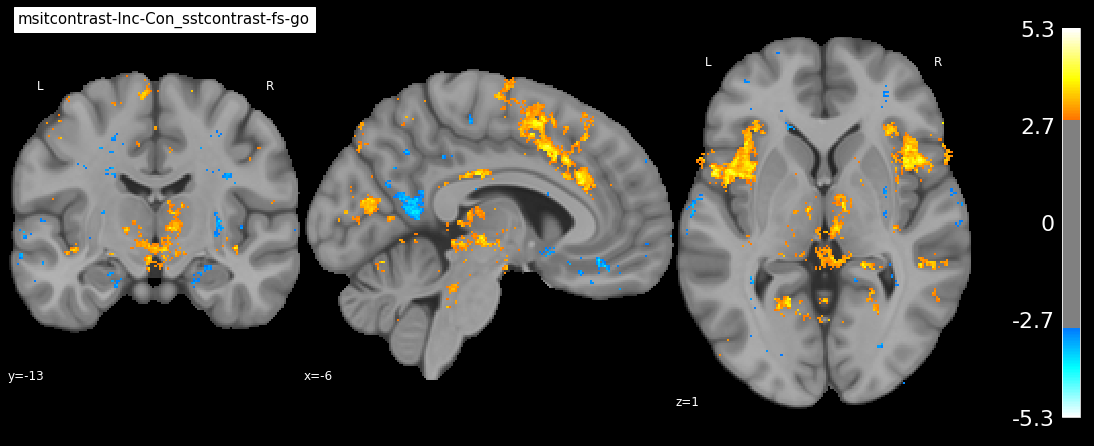

In [258]:
#1p5
first_level_contrast, second_level_contrast, fwhm, _ = all_combs[0]
fwhm = str(fwhm).replace('.', 'p')
# z_map = nib.load(f'../derivatives/glm_nilearn/group_level_model/ses-sstmsit/fwhm-{fwhm}/model-0/firstlevelcontrast-{first_level_contrast}_secondlevelcontrast-{second_level_contrast}.nii.gz')
z_map = nib.load(f'/home/scotti/test_nilearn_conj/fwhm-{fwhm}/model-{_}/firstlevelcontrast-msitcontrast-Inc-Con_sstcontrast-fs-go_secondlevelcontrast-intercept.nii.gz')
plotting.plot_stat_map(z_map, threshold=2.9, title=first_level_contrast, bg_img=mni09c, cut_coords=[-6, -13, 1], draw_cross=False)
plt.gcf().set_size_inches(15,6)

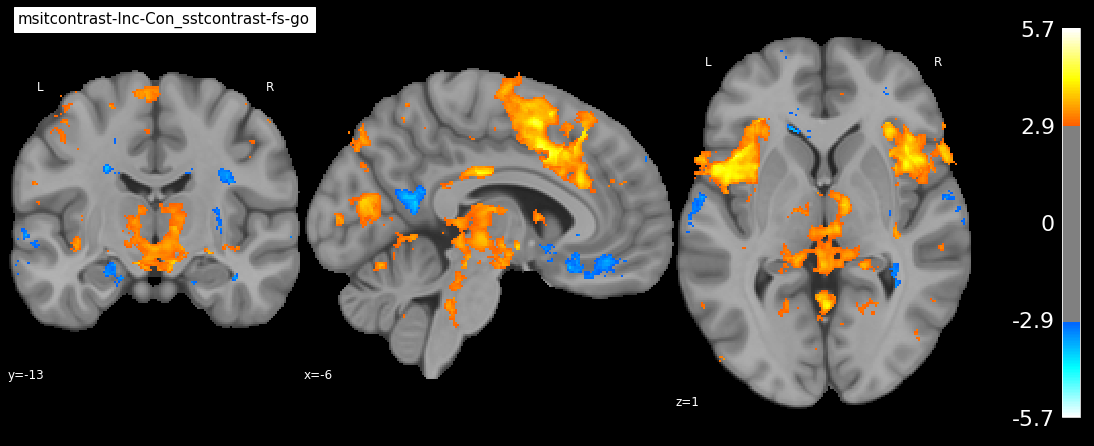

In [254]:
# 4p5
first_level_contrast, second_level_contrast, fwhm, _ = all_combs[0]
fwhm = str(fwhm).replace('.', 'p')
# z_map = nib.load(f'../derivatives/glm_nilearn/group_level_model/ses-sstmsit/fwhm-{fwhm}/model-0/firstlevelcontrast-{first_level_contrast}_secondlevelcontrast-{second_level_contrast}.nii.gz')
z_map = nib.load(f'/home/scotti/test_nilearn_conj/fwhm-{fwhm}/model-{_}/firstlevelcontrast-msitcontrast-Inc-Con_sstcontrast-fs-go_secondlevelcontrast-intercept.nii.gz')
plotting.plot_stat_map(z_map, threshold=2.9, title=first_level_contrast, bg_img=mni09c, cut_coords=[-6, -13, 1], draw_cross=False)
plt.gcf().set_size_inches(15,6)

/home/scotti/.conda/envs/py38/lib/python3.8/site-packages/nilearn/plotting/displays.py:97: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Text(0.5, 1.0, 'z-value')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


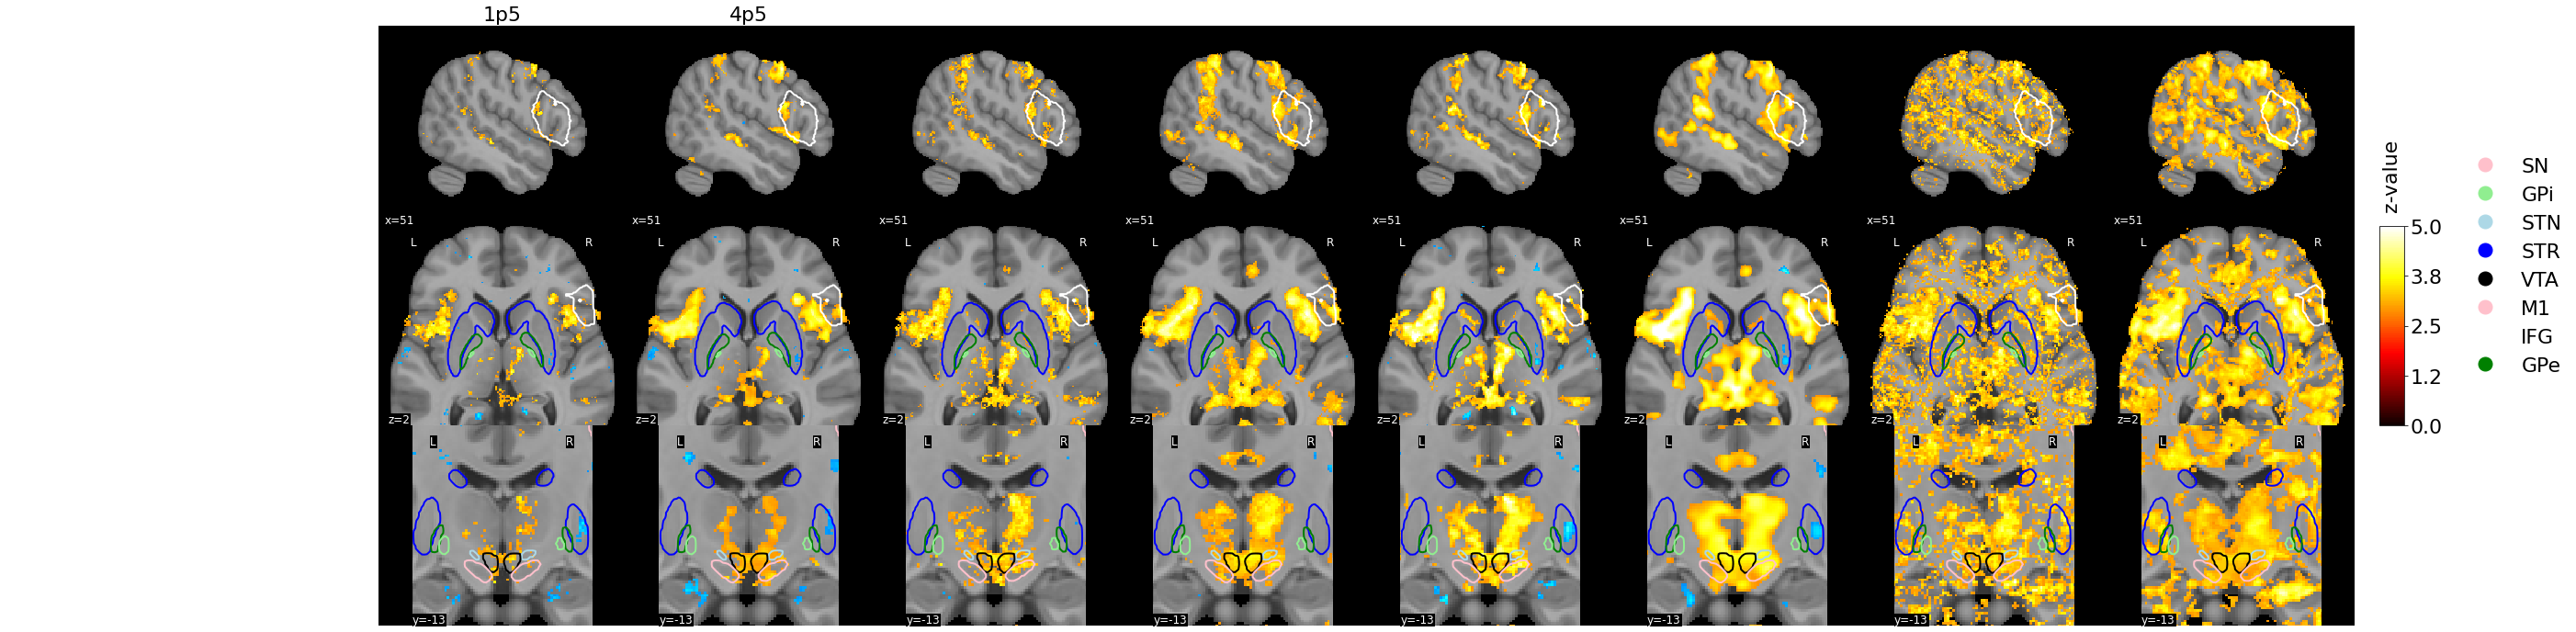

In [3]:
zmaps = []
for cmethod in ['min','max','sum','multiply']:
    for fwhm in ['1p5','4p5']:
        zmaps.append(f'/home/scotti/test_nilearn_conj/{cmethod}/fwhm-{fwhm}/model-0/firstlevelcontrast-msitcontrast-Inc-Con_sstcontrast-fs-go_secondlevelcontrast-intercept.nii.gz')

# zmaps = [nib.load(f'/home/scotti/test_nilearn_conj/max/fwhm-1p5/model-0/firstlevelcontrast-msitcontrast-Inc-Con_sstcontrast-fs-go_secondlevelcontrast-intercept.nii.gz'), 
#          nib.load(f'/home/scotti/test_nilearn_conj/max/fwhm-4p5/model-0/firstlevelcontrast-msitcontrast-Inc-Con_sstcontrast-fs-go_secondlevelcontrast-intercept.nii.gz'),
#          nib.load(f'/home/scotti/test_nilearn_conj/min/fwhm-1p5/model-0/firstlevelcontrast-msitcontrast-Inc-Con_sstcontrast-fs-go_secondlevelcontrast-intercept.nii.gz'), 
#          nib.load(f'/home/scotti/test_nilearn_conj/min/fwhm-4p5/model-0/firstlevelcontrast-msitcontrast-Inc-Con_sstcontrast-fs-go_secondlevelcontrast-intercept.nii.gz'),
#          nib.load(f'/home/scotti/test_nilearn_conj/sum/fwhm-1p5/model-0/firstlevelcontrast-msitcontrast-Inc-Con_sstcontrast-fs-go_secondlevelcontrast-intercept.nii.gz'), 
#          nib.load(f'/home/scotti/test_nilearn_conj/sum/fwhm-4p5/model-0/firstlevelcontrast-msitcontrast-Inc-Con_sstcontrast-fs-go_secondlevelcontrast-intercept.nii.gz'),
#          nib.load(f'/home/scotti/test_nilearn_conj/multiply/fwhm-1p5/model-0/firstlevelcontrast-msitcontrast-Inc-Con_sstcontrast-fs-go_secondlevelcontrast-intercept.nii.gz'), 
#          nib.load(f'/home/scotti/test_nilearn_conj/multiply/fwhm-4p5/model-0/firstlevelcontrast-msitcontrast-Inc-Con_sstcontrast-fs-go_secondlevelcontrast-intercept.nii.gz')]

mni09c = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

# plot t maps for smoothed images
fontsize = 22
vmax = 5
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, roi_dict=get_roi_dict(),z_threshold=2.9,f=f, axes=axes,roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],bg_img=mni09c,vmax=vmax, plot_columns=(0,1,2,3,4,5,6,7),annotate=True, empty_plots=False, skip_all_but_last=False)
axes[0,0].set_title('min 1p5')
axes[0,1].set_title('min 4p5')
axes[0,0].set_title('max 1p5')
axes[0,1].set_title('max 4p5')
axes[0,0].set_title('sum 1p5')
axes[0,1].set_title('sum 4p5')
axes[0,0].set_title('multiply 1p5')
axes[0,1].set_title('multiply 4p5')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# NEW METHOD

## do conjunction of SS - GO and INC - CON

In [4]:
# load both images to be conjuncted
# sst_img = '/home/Public/trondheim/derivatives/glm_feat/group_level_model/ses-sstmsit/task-sst/model-0/model-0_fwhm-1p5_subjectlevelcontrast-5_grouplevelcontrast-1_flame-12_desc-zstat.nii.gz'
# msit_img = '/home/Public/trondheim/derivatives/glm_feat/group_level_model/ses-sstmsit/task-msit/model-0/model-0/model-0_fwhm-1p5_subjectlevelcontrast-6_grouplevelcontrast-1_flame-12_desc-zstat.nii.gz'

msit_img = '/home/Public/trondheim/derivatives/glm_feat/group_level_model/ses-sstmsit/task-msit/model-0/model-0_fwhm-1p5_subjectlevelcontrast-6_grouplevelcontrast-1_flame-12_desc-zstat.nii.gz'
sst_img = '/home/Public/trondheim/derivatives/glm_feat/group_level_model/ses-sstmsit_old/task-sst/third_level_model/level3_zstats/_contrast_n_5_fwhm_1p5_model_n_0/zstat1.nii.gz'

In [5]:
from nilearn.glm import threshold_stats_img
_sst, threshold_sst = threshold_stats_img(sst_img, alpha=0.05, height_control='fdr')
_msit, threshold_msit = threshold_stats_img(msit_img, alpha=0.05, height_control='fdr')

In [6]:
print(threshold_msit)
print(threshold_sst)

print('both are lower than 3.1, so dont need to threshold them as 3.1 is the minimum threshold anyway woop woop')

2.9716529846181405
3.006840944289161
both are lower than 3.1, so dont need to threshold them as 3.1 is the minimum threshold anyway woop woop


In [7]:
subprocess.call(['./easythresh_conj.sh', 
                '/home/Public/trondheim/derivatives/glm_feat/group_level_model/ses-sstmsit_old/task-sst/third_level_model/level3_zstats/_contrast_n_5_fwhm_1p5_model_n_0/zstat1.nii.gz',
                '/home/Public/trondheim/derivatives/glm_feat/group_level_model/ses-sstmsit/task-msit/model-0/model-0_fwhm-1p5_subjectlevelcontrast-6_grouplevelcontrast-1_flame-12_desc-zstat.nii.gz',
                 '3.1',
                '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii',
#                 '0.01',
                'ss-go_inc-con_conjmap'
                ], cwd='/home/scotti/projects/ntnu_fmri')

0

In [8]:
conj_map = '/home/scotti/projects/ntnu_fmri/zstat_min_ss-go_inc-con_conjmap.nii.gz'

In [37]:
mappy_load = nib.load(conj_map)
mappy = mappy_load.get_fdata()
mappy[mappy<=3.1] = 0
mappy_img = nib.Nifti1Image(mappy,affine=mappy_load.affine)
mappy_img.to_filename('/home/scotti/projects/ntnu_fmri/zstat_min_ss-go_inc-con_conjmap_no_negs.nii.gz')

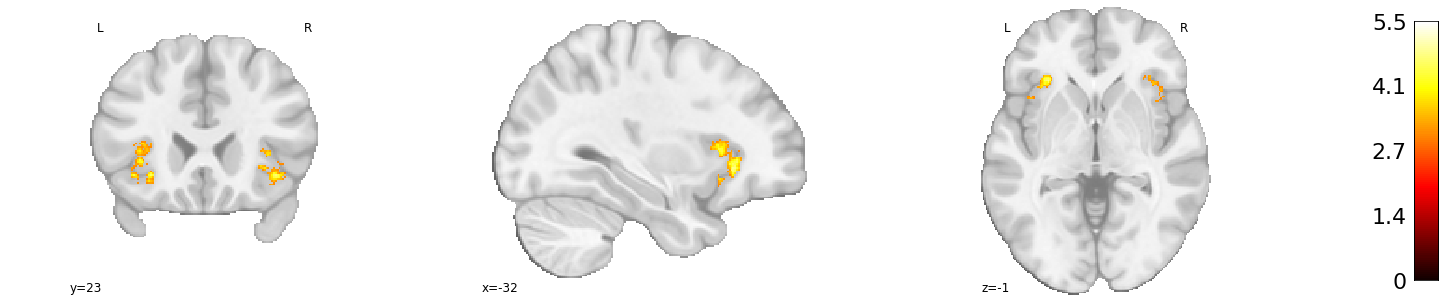

In [38]:
fig = plt.figure(figsize=(20, 4))
plotting.plot_stat_map(mappy_img, draw_cross=False,figure=fig, bg_img=mni09c, black_bg = False)

Text(0.5, 1.0, 'z-value')

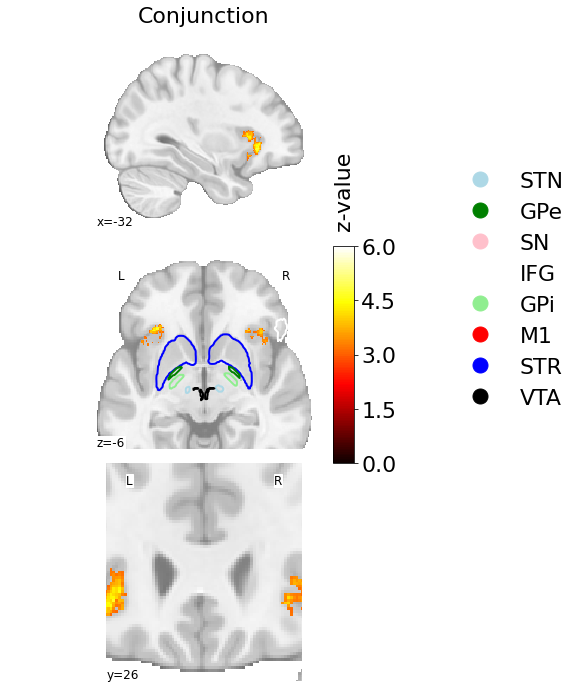

In [16]:
zmaps = [mappy_img]
mni09c = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

# plot t maps for smoothed images
fontsize = 22
vmax = 6
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, roi_dict=get_roi_dict(),z_threshold=3.1,f=f, axes=axes,roi_to_plot=['rIFG', 'STR', 'STN'],cut_coords=[[-32], [-6], [26]],bg_img=mni09c,vmax=vmax, plot_columns=(0, 1, 2),annotate=True, empty_plots=False, black_bg=False,skip_all_but_last=False)
axes[0,0].set_title('Conjunction')

for row in range(axes.shape[0]):
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)


In [19]:
import subprocess

### First, threshold and FDR correct images before creating conjunction

In [20]:
from nilearn.glm import threshold_stats_img

In [51]:
# load both images to be conjuncted
sst_img = '/home/Public/trondheim/derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-sst/model-0/model-0/model-0_fwhm-1p5_subjectlevelcontrast-3_grouplevelcontrast-1_flame-12_desc-zstat.nii.gz'
msit_img = '/home/Public/trondheim/derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-msit/model-0/model-0/model-0_fwhm-1p5_subjectlevelcontrast-6_grouplevelcontrast-1_flame-12_desc-zstat.nii.gz',

In [52]:
_sst, threshold_sst = threshold_stats_img(sst_img, alpha=0.05, height_control='fdr')
_msit, threshold_msit = threshold_stats_img(msit_img, alpha=0.05, height_control='fdr')

In [57]:
print(threshold_msit)
print(threshold_sst)

print('both are lower than 3.1, so dont need to threshold them as 3.1 is the minimum threshold anyway woop woop')

2.864088773726417
2.489342212676002
both are lower than 3.1, so dont need to threshold them as 3.1 is the minimum threshold anyway woop woop


### do the conjunction

easythresh_conj stats/tstat1 stats/tstat2 2.1 struc/template_GM conj_tstat1_tstat2

"Usage: easythresh_conj [-s SmoothEst] <raw_zstat1> <raw_zstat2> <brain_mask> <cluster_z_thresh> <cluster_prob_thresh> <background_image> <output_root> [--mm]"

In [48]:
subprocess.call(['./easythresh_conj.sh', 
                '/home/Public/trondheim/derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-sst/model-0/model-0/model-0_fwhm-1p5_subjectlevelcontrast-3_grouplevelcontrast-1_flame-12_desc-zstat.nii.gz',
                '/home/Public/trondheim/derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-msit/model-0/model-0/model-0_fwhm-1p5_subjectlevelcontrast-6_grouplevelcontrast-1_flame-12_desc-zstat.nii.gz',
                 '3.1',
                '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii',
#                 '0.01',
                'fs-go_inc-con_conjmap'
                ], cwd='/home/scotti/projects/ntnu_fmri')

0

In [5]:
conj_map = '/home/scotti/projects/ntnu_fmri/zstat_min_fs-go_inc-con_conjmap.nii.gz'

In [6]:
mappy = nib.load(conj_map).get_fdata()
mappy[mappy<=0] = 0


/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Text(0.5, 1.0, 'z-value')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


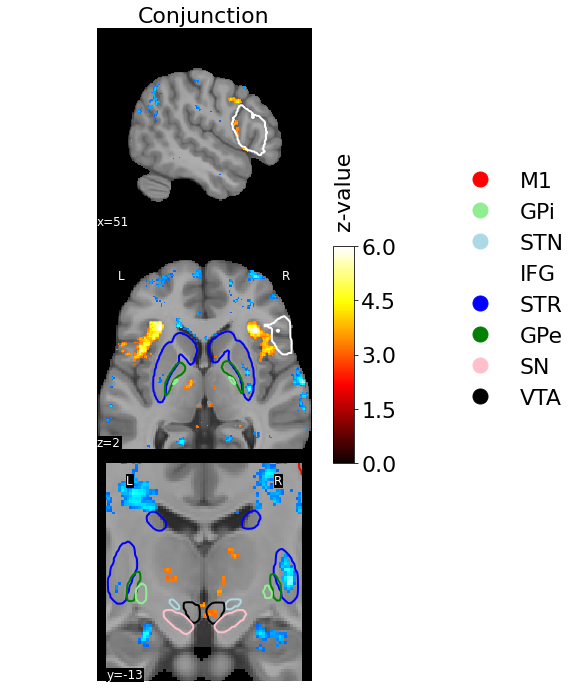

In [7]:
zmaps = [conj_map]
mni09c = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

# plot t maps for smoothed images
fontsize = 22
vmax = 6
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, roi_dict=get_roi_dict(),z_threshold=3.1,f=f, axes=axes,roi_to_plot=['rIFG', 'STR', 'STN'],cut_coords=[[51], [2], [-13]],bg_img=mni09c,vmax=vmax, plot_columns=(0, 1, 2),annotate=True, empty_plots=False, skip_all_but_last=False)
axes[0,0].set_title('Conjunction')

for row in range(axes.shape[0]):
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

## do conjunction of SS and INC

this is the conjunction map of interest

In [59]:
subprocess.call(['./easythresh_conj.sh', 
                '/home/Public/trondheim/derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-sst/model-0/model-0/model-0_fwhm-1p5_subjectlevelcontrast-1_grouplevelcontrast-1_flame-12_desc-zstat.nii.gz',
#                 '/home/Public/trondheim/derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-msit/model-0/model-0/model-0_fwhm-1p5_subjectlevelcontrast-3_grouplevelcontrast-1_flame-12_desc-zstat.nii.gz',
                '/home/Public/trondheim/derivatives/glm_feat/group_level_model/ses-sstmsit/task-msit/model-0/model-0_fwhm-1p5_subjectlevelcontrast-3_grouplevelcontrast-1_flame-12_desc-zstat.nii.gz',
                '3.1',
                '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii',
#                 '0.01',
                'ss_inc_conjmap'
                ], cwd='/home/scotti/projects/ntnu_fmri')

0

In [4]:
conj_map = '/home/scotti/projects/ntnu_fmri/zstat_min_ss_inc_conjmap_no_negs.nii.gz'

In [68]:
mappy = nib.load(conj_map).get_fdata()
mappy[mappy<=0] = 0
to_save = nib.Nifti1Image(mappy,nib.load(conj_map).affine)
to_save.to_filename('/home/scotti/projects/ntnu_fmri/zstat_min_ss_inc_conjmap_no_negs.nii.gz')


/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Text(0.5, 1.0, 'z-value')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


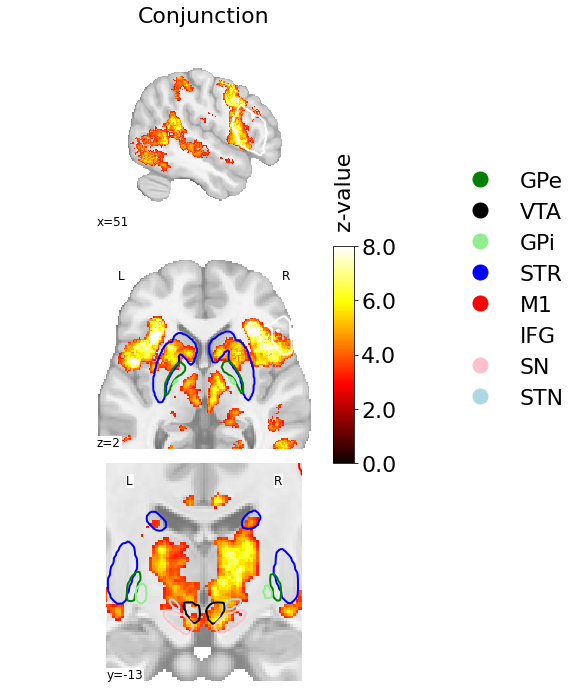

In [5]:
zmaps = [conj_map]
mni09c = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

# plot t maps for smoothed images
fontsize = 22
vmax = 8
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, roi_dict=get_roi_dict(),z_threshold=3.1,f=f,
                          axes=axes,roi_to_plot=['rIFG', 'STR', 'STN'],cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,vmax=vmax, plot_columns=(0, 1, 2),annotate=True, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)

axes[0,0].set_title('Conjunction')

for row in range(axes.shape[0]):
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# ICON

In [62]:
import nistats
import nibabel as nib
import nilearn
from nilearn import image
#from nistats.first_level_model import FirstLevelModel
#from nistats.second_level_model import SecondLevelModel
#from nistats.thresholding import map_threshold
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn import plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl
from plotting_utils import *

# t1w background image template
# mni09c = '/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'
mni09c = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

%matplotlib inline

In [63]:
def merge_pos_neg(pos, neg):
    return image.math_img('pos-neg', pos=pos, neg=neg)

def get_second_level_zmap(first_level_contrast, second_level_contrast, fwhm='1p5', task='sst', model_n=0, thresholding=None, threshold_z=3.1, hp=False,
                          base_dir='../derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-sst',
                          from_working_dir=False, 
                          flame='1'):
    
    if task=='msit':
        base_dir='../derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-msit'
    
    # Look-up dictionaries
    if task == 'sst':
        if model_n == 0:
            first_level_copes = {'fs': 0,
                                 'ss': 1,
                                 'go': 2,
                                 'fs-go': 3,
                                 'fs-ss': 4,
                                 'ss-go': 5,
                                 'left-right': 0
                                 }

            second_level_copes = {'intercept': 1,
                                  '-intercept': 2}
        elif model_n == 1:
            first_level_copes = {'response_left': 0,
                                 'response_right': 1,
                                 'left-right': 2}

            second_level_copes = {'intercept': 1,
                                  '-intercept': 2}
    elif task == 'msit':
        if model_n == 0:
            first_level_copes = {'con': 0,
                         'simon': 1,
                         'flanker': 2,
                         'inc': 3,
                         'simon-con': 4,
                         'flanker-con': 5,
                         'inc-con': 6,
                         'simon-flanker': 7,
                         'inc-simon': 8,
                         'inc-flanker': 9,
                         'timing_feedback': 10
                         }

            second_level_copes = {'intercept': 1,
                                  '-intercept': 2}
    
    cope1 = first_level_copes[first_level_contrast]
    cope2 = second_level_copes[second_level_contrast]
    
    if hp:
        model_suffix = '_hp'
    else:
        model_suffix = ''

    if thresholding is None or thresholding == 'fdr':
        if from_working_dir:
            nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_sstmsit_hp/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_flame{flame}/flameo/stats/zstat{cope2}.nii.gz')
        else:
            nii = nib.load(os.path.join(base_dir, f'model-{model_n}{model_suffix}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat.nii.gz'))
        
        if thresholding is None:
            threshold = 0
        else:
            _, threshold = threshold_stats_img(nii, alpha=0.05, height_control='fdr')
            
    elif thresholding == 'fwer' or thresholding == 'cluster':
        
        # if from_working_dir:
        #     nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_rlsat/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_{run_mode}/flameo/stats/zstat{cope2}.nii.gz')        
        nii_pos = nib.load(os.path.join(base_dir, f'model-{model_n}{model_suffix}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))
        nii_neg = nib.load(os.path.join(base_dir, f'model-{model_n}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2+1}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))

        nii = merge_pos_neg(nii_pos, nii_neg)
        threshold = np.min(nii_pos.get_fdata())
        

    return nii, threshold

def plot_4x4(z_map, n_cuts=16, display_mode='z', **kwargs):
    cols = rows = int(np.sqrt(n_cuts))
    
    gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 1, 1.3])
    f, axes = plt.subplots(4, 4, gridspec_kw=gridspec)
    ax = axes.ravel()
    
    cut_coords = nilearn.plotting.find_cut_slices(z_map, direction=display_mode, n_cuts=n_cuts)
    
    if(z_map.get_fdata().sum() == 0):
        print('No non-zero z-values, nothing to plot!')
        return f, ax
    
    for i in range(n_cuts):
        # plot colorbar in right-most column
        if ((i+1)/cols % cols) == int(((i+1)/cols % cols)):
            colorbar = True
        else:
            colorbar = False
        
        if i == 0 and 'title' in kwargs.keys():
            title = kwargs.pop('title')
        else:
            title = None
        
        plotting.plot_stat_map(z_map, display_mode=display_mode, colorbar=colorbar, title=title,
                               cut_coords=[cut_coords[i]], figure=f, axes=ax[i], **kwargs)
        
    f.set_size_inches(15,15)
    return f, ax

In [72]:
zmap_fsgo, thresh1 = get_second_level_zmap('fs-go', 'intercept', thresholding='fdr',task='sst',model_n=0,from_working_dir=False, flame='12')
zmap_ssgo, thresh2 = get_second_level_zmap('ss-go', 'intercept', thresholding='fdr',task='sst',model_n=0,from_working_dir=False, flame='12')
zmap_fsss, thresh3 = get_second_level_zmap('fs-ss', 'intercept', thresholding='fdr',task='sst',model_n=0,from_working_dir=False, flame='12')
zmap_inccon, thresh4 = get_second_level_zmap('inc-con', 'intercept', thresholding='fdr',task='msit',model_n=0,from_working_dir=False, flame='12')
conj_map = '/home/scotti/projects/ntnu_fmri/zstat_min_ss_inc_conjmap_no_negs.nii.gz'

zmaps=[zmap_fsgo, zmap_ssgo, zmap_fsss,zmap_inccon,conj_map]

thr = [thresh1,thresh2,thresh3,thresh4,3.1]

In [23]:
zmaps

 '/home/scotti/projects/ntnu_fmri/zstat_min_fs-go_inc-con_conjmap.nii.gz']

Text(0.5, 1.0, 'z-value')

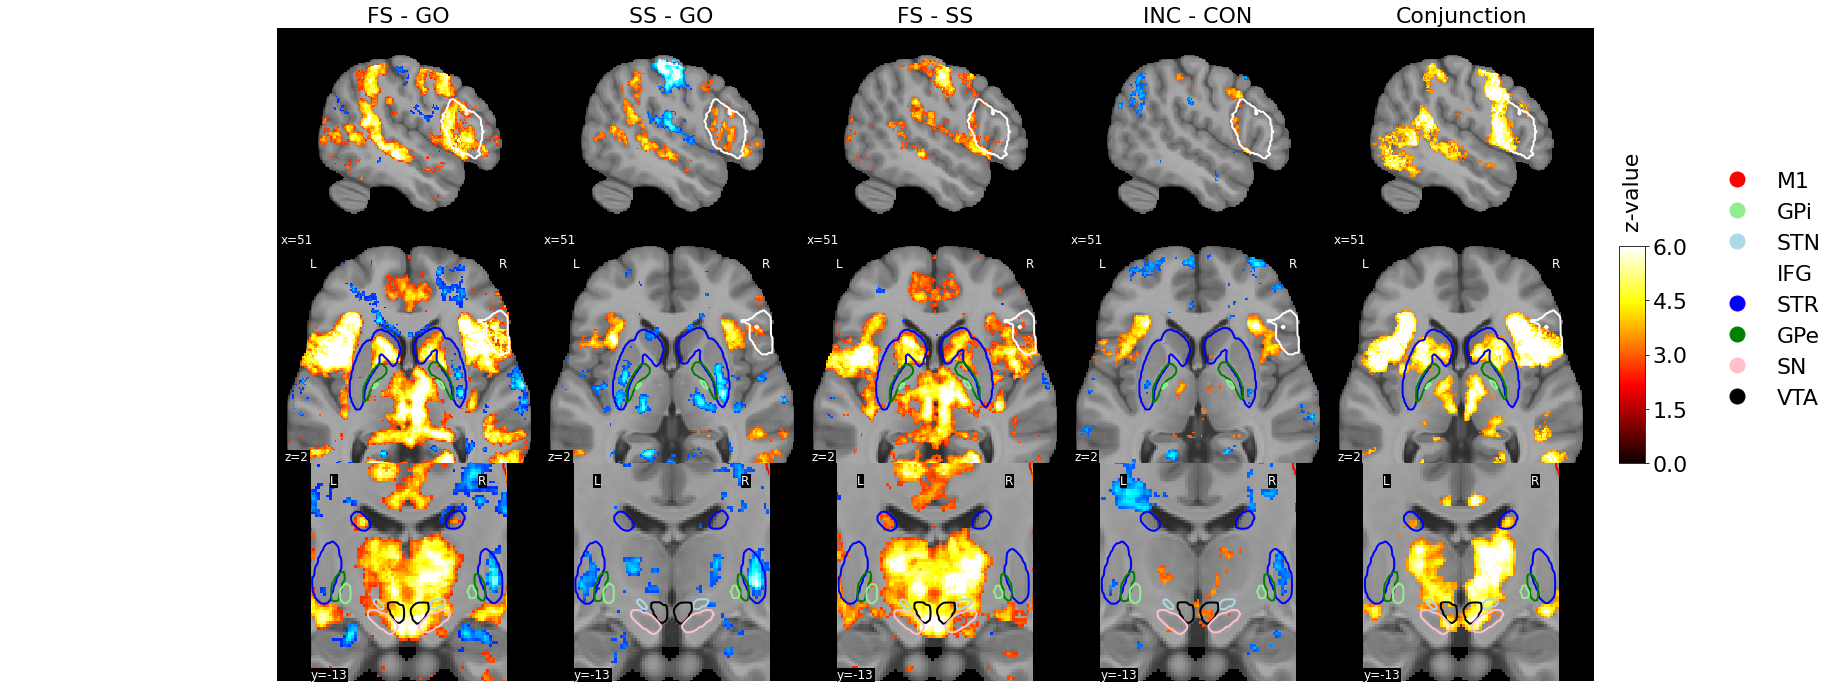

In [73]:
# zmaps = [conj_map]
mni09c = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

# plot t maps for smoothed images
fontsize = 22
vmax = 6
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, roi_dict=get_roi_dict(),z_threshold=thr,f=f, axes=axes,roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],bg_img=mni09c,vmax=vmax, 
                          plot_columns=(0, 1, 2,3,4,5,6),annotate=True, empty_plots=False, skip_all_but_last=False)
axes[0,0].set_title('FS - GO')
axes[0,1].set_title('SS - GO')
axes[0,2].set_title('FS - SS')
axes[0,3].set_title('INC - CON')
axes[0,4].set_title('Conjunction')

for row in range(axes.shape[0]):
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

Text(0.5, 1.0, 'z-value')

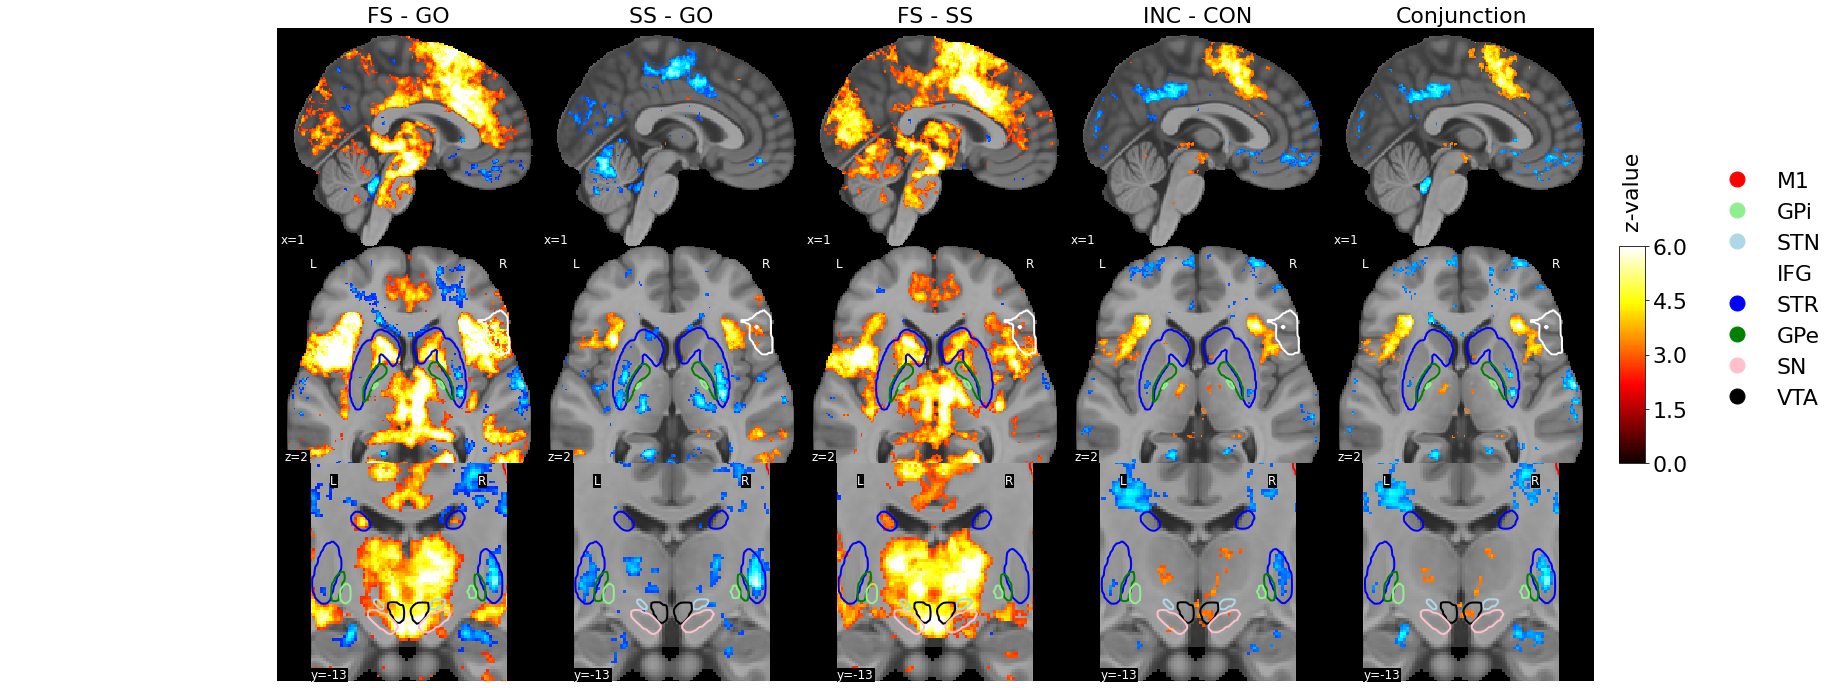

In [28]:
# zmaps = [conj_map]
mni09c = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

# plot t maps for smoothed images
fontsize = 22
vmax = 6
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, roi_dict=get_roi_dict(),z_threshold=thr,f=f, axes=axes,roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[1], [2], [-13]],bg_img=mni09c,vmax=vmax, 
                          plot_columns=(0, 1, 2,3,4,5,6),annotate=True, empty_plots=False, skip_all_but_last=False)
axes[0,0].set_title('FS - GO')
axes[0,1].set_title('SS - GO')
axes[0,2].set_title('FS - SS')
axes[0,3].set_title('INC - CON')
axes[0,4].set_title('Conjunction')

for row in range(axes.shape[0]):
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# conjunction only

In [3]:
zmaps = [conj_map]
mni09c = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

# plot t maps for smoothed images
fontsize = 22
vmax = 8
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, roi_dict=get_roi_dict(),z_threshold=3.1,f=f, axes=axes,roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],bg_img=mni09c,vmax=vmax, 
                          plot_columns=(0, 1, 2),annotate=True, empty_plots=False, skip_all_but_last=False, black_bg=False)
axes[0,0].set_title('Conjunction')

for row in range(axes.shape[0]):
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

NameError: name 'conj_map' is not defined

# SUBTRACTion ANALYSIS

actual subtraction doesnt make sense..

what about keeping only voxels significantly activated when not significantly activated in the other task

In [17]:
def subtraction(map1, map2):
    
    formula = "img - img2"
    img_sub = math_img(formula, img=map1, img2=map2)
    
    return img_sub

In [21]:
# load SS contrast from SST and INC contrast from MSIT
# sst_ss = '/home/Public/trondheim/derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-sst/model-0/model-0/model-0_fwhm-1p5_subjectlevelcontrast-1_grouplevelcontrast-1_flame-12_desc-zstat_voxelthreshold-3.1.nii.gz'
# msit_inc = '/home/Public/trondheim/derivatives/glm_feat/group_level_model/ses-sstmsit/task-msit/model-0/model-0_fwhm-1p5_subjectlevelcontrast-3_grouplevelcontrast-1_flame-12_desc-zstat_voxelthreshold-3.1.nii.gz'

msit_inc = '/home/Public/trondheim/derivatives/glm_feat/group_level_model/ses-sstmsit/task-msit/model-0/model-0_fwhm-1p5_subjectlevelcontrast-6_grouplevelcontrast-1_flame-12_desc-zstat_voxelthreshold-3.1.nii.gz'
# sst_ss = '/home/Public/trondheim/derivatives/glm_feat/group_level_model/ses-sstmsit_old/task-sst/third_level_model/level3_zstats/_contrast_n_5_fwhm_1p5_model_n_0/zstat1.nii.gz'
sst_ss = '/home/Public/trondheim/derivatives/glm_feat/group_level_model/ses-sstmsit_old/task-sst/grf_thresholded_zstats_file/_contrast_n_5_fwhm_1p5_model_n_0/_threshold_3.1/_grf_cluster0/zstat1_threshold.nii.gz'

In [22]:
# show which voxels are significantly activated in MSIT but not SST
sst_af = nib.load(sst_ss)
sst_ = sst_af.get_fdata()

sst_[sst_<3.1] = 1
sst_[sst_>=3.1] = 0
sst_nii = nib.Nifti1Image(sst_, affine=sst_af.affine)

msit_af = nib.load(msit_inc)
msit_ = msit_af.get_fdata()

msit_subtr = msit_*sst_

msit_subtr_nii = nib.Nifti1Image(msit_subtr, affine=msit_af.affine)
msit_subtr_nii.to_filename('/home/scotti/projects/ntnu_fmri/msit_minus_sst.nii.gz')

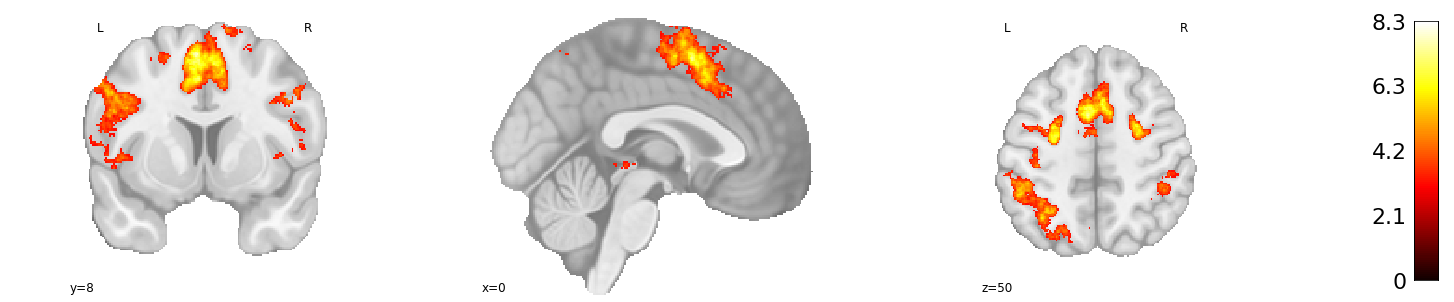

In [33]:
fig = plt.figure(figsize=(20, 4))
plotting.plot_stat_map(msit_subtr_nii, draw_cross=False,figure=fig, bg_img=mni09c, black_bg = False)
# plotting.plot_stat_map(msit_subtr_nii, draw_cross=False)

In [24]:
# show which voxels are significantly activated in SST but not MSIT
msit_af = nib.load(msit_inc)
msit_ = msit_af.get_fdata()
msit_[msit_<3.1] = 1
msit_[msit_>=3.1] = 0
msit_nii = nib.Nifti1Image(msit_, affine=msit_af.affine)

sst_af = nib.load(sst_ss)
sst_ = sst_af.get_fdata()

sst_subtr = msit_*sst_

sst_subtr_nii = nib.Nifti1Image(sst_subtr, affine=sst_af.affine)
sst_subtr_nii.to_filename('/home/scotti/projects/ntnu_fmri/sst_minus_msit.nii.gz')

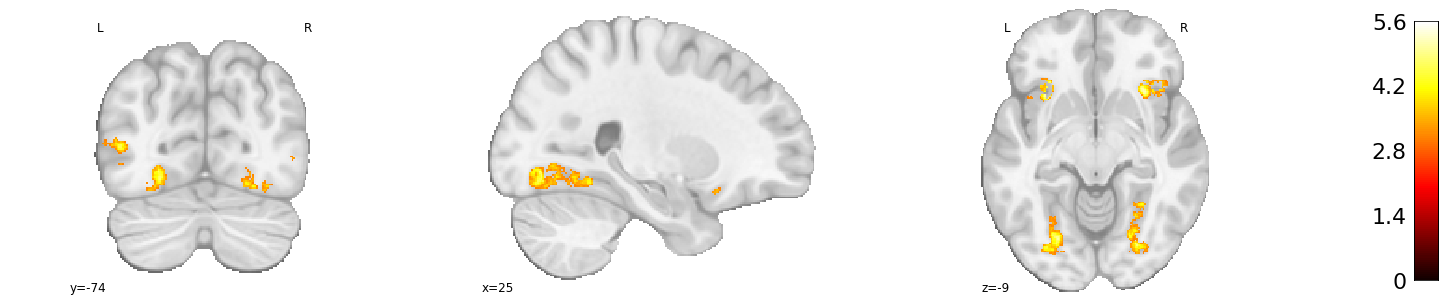

In [34]:
fig = plt.figure(figsize=(20, 4))
plotting.plot_stat_map(sst_subtr_nii, draw_cross=False,figure=fig, bg_img=mni09c, black_bg = False)

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Text(0.5, 1.0, 'z-value')

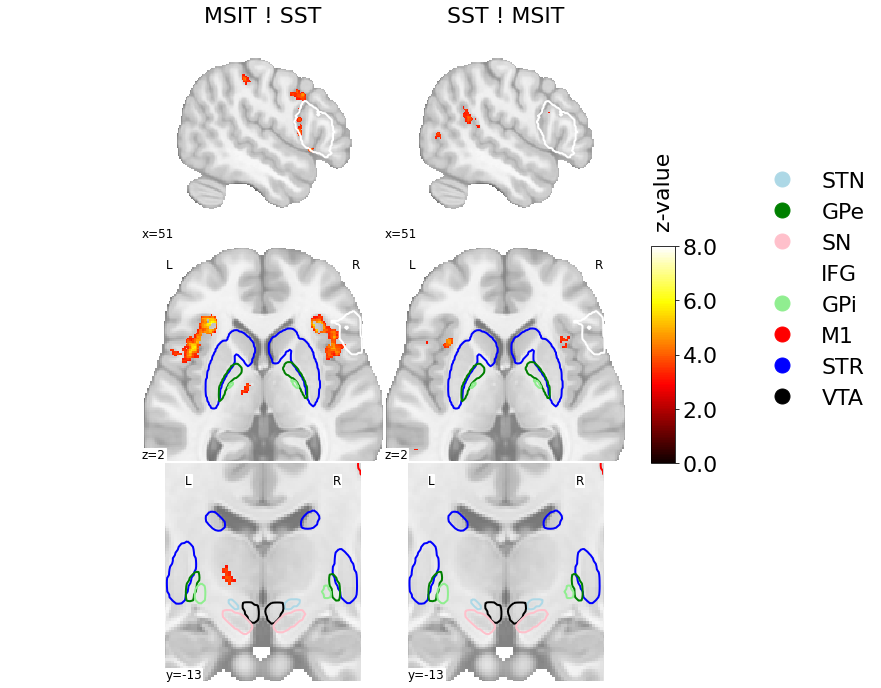

In [26]:
zmaps = ['/home/scotti/projects/ntnu_fmri/msit_minus_sst.nii.gz', '/home/scotti/projects/ntnu_fmri/sst_minus_msit.nii.gz']
mni09c = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

# plot t maps for smoothed images
fontsize = 22
vmax = 8
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, roi_dict=get_roi_dict(),z_threshold=3.1,f=f, axes=axes,roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],bg_img=mni09c,vmax=vmax, 
                          plot_columns=(0, 1, 2,3),annotate=True, empty_plots=False, black_bg=False,skip_all_but_last=False)
axes[0,0].set_title('MSIT ! SST')
axes[0,1].set_title('SST ! MSIT')

for row in range(axes.shape[0]):
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

## extend the subtraction analysis

dilate conjunction plot by 2 voxels to stop borders being significant in subtraction plot

nullify voxels that are only small clusters

In [3]:
# first, binarize conj image
conj_path = '/home/scotti/projects/ntnu_fmri/zstat_min_ss_inc_conjmap_no_negs.nii.gz'
conj_img = nib.load(conj_path)
conj_data = conj_img.get_fdata()
conj_bin = np.where(conj_data>3.09,1,0)
nib.Nifti1Image(conj_bin, affine=conj_img.affine).to_filename('/home/scotti/projects/ntnu_fmri/zstat_min_ss_inc_conjmap_no_negs_bin.nii.gz')


In [4]:
# struct = ndimage.generate_binary_structure(2, 2)
conj_dil = ndimage.binary_dilation(conj_bin, iterations=2).astype(conj_bin.dtype)
nib.Nifti1Image(conj_dil, affine=conj_img.affine).to_filename('/home/scotti/projects/ntnu_fmri/zstat_min_ss_inc_conjmap_no_negs_bin_dil.nii.gz')

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


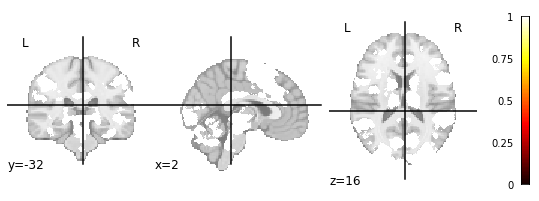

In [5]:
plotting.plot_stat_map('/home/scotti/projects/ntnu_fmri/zstat_min_ss_inc_conjmap_no_negs_bin_dil.nii.gz')

In [6]:
# cool, now use the dilated mask to remove some leak over activaiton in the msit map

In [7]:
msit_map = '/home/scotti/projects/ntnu_fmri/test_subtr_msit.nii.gz'
msit_img = nib.load(msit_map)
msit_data = msit_img.get_fdata()
dil_map = '/home/scotti/projects/ntnu_fmri/zstat_min_ss_inc_conjmap_no_negs_bin_dil.nii.gz'
dil_img = nib.load(dil_map)
dil_data = dil_img.get_fdata()
dil_data = 1 - dil_data

msit_dil = msit_data * dil_data

In [8]:
nib.Nifti1Image(msit_dil, affine=msit_img.affine).to_filename('/home/scotti/projects/ntnu_fmri/test_subtr_msit_dilated.nii.gz')

In [23]:
import numpy as np
from skimage import io, morphology
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
from skimage import io, morphology
import matplotlib.pyplot as plt

img = np.array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
                [255, 255,   0, 255,   0,   0,   0,   0, 255, 255, 255],
                [255, 255, 255, 255,   0,   0,   0,   0, 255,   0,   0],
                [255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                [255, 255,   0,   0,   0,   0,   0, 255,   0,   0,   0],
                [255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                [255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0],
                [255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                [255, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

arr = img > 0
cleaned = morphology.remove_small_objects(arr, min_size=2)
cleaned = morphology.remove_small_holes(cleaned, min_size=2)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img, cmap='gray')
axs[0].set_title('img')
axs[1].imshow(cleaned, cmap='gray')
axs[1].set_title('cleaned')
plt.show(fig)

In [25]:
msit_dil = msit_dil.astype(int)

In [43]:
cleaned = morphology.remove_small_objects(msit_dil, min_size=10000)
# cleaned = morphology.remove_small_holes(cleaned)
nib.Nifti1Image(cleaned, affine=msit_img.affine).to_filename('/home/scotti/projects/ntnu_fmri/test_subtr_msit_dil_cleaned.nii.gz')

In [44]:
cleaned.sum()

557541

In [31]:
msit_dil.sum()

670842

In [40]:
morphology.remove_small_holes

<function skimage.morphology.misc.remove_small_holes(ar, area_threshold=64, connectivity=1, in_place=False, *, out=None)>

# SMOOTHING SUBTRACTION

In [6]:
from nilearn.glm import threshold_stats_img

In [11]:
# get thresholded zmaps
# load SS contrast from SST and INC contrast from MSIT
sst_ss = '/home/Public/trondheim/derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-sst/model-0/model-0/model-0_fwhm-1p5_subjectlevelcontrast-1_grouplevelcontrast-1_flame-12_desc-zstat_voxelthreshold-3.1.nii.gz'
_SS, threshold_SS = threshold_stats_img(sst_ss, alpha=0.05, height_control='fdr')
msit_inc = '/home/Public/trondheim/derivatives/glm_feat/group_level_model/ses-sstmsit/task-msit/model-0/model-0_fwhm-1p5_subjectlevelcontrast-3_grouplevelcontrast-1_flame-12_desc-zstat_voxelthreshold-3.1.nii.gz'
_INC, threshold_INC = threshold_stats_img(msit_inc, alpha=0.05, height_control='fdr')

In [12]:
# smooth thresholded zmaps
smooth_SS, smooth_INC = nilearn.image.smooth_img([_SS,_INC], fwhm=1.5)

In [13]:
# smooth subtraction maps instead
subtr_INC_SS = '/home/scotti/projects/ntnu_fmri/test_subtr_msit.nii.gz'
subtr_SS_INC= '/home/scotti/projects/ntnu_fmri/test_subtr_sst.nii.gz'

smooth_INC, smooth_SS = nilearn.image.smooth_img([subtr_INC_SS,subtr_SS_INC], fwhm=1.5)

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Text(0.5, 1.0, 'z-value')

WARNING - 2022-06-26 18:00:30,637 - font_manager - findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
WARNING - 2022-06-26 18:00:30,911 - font_manager - findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


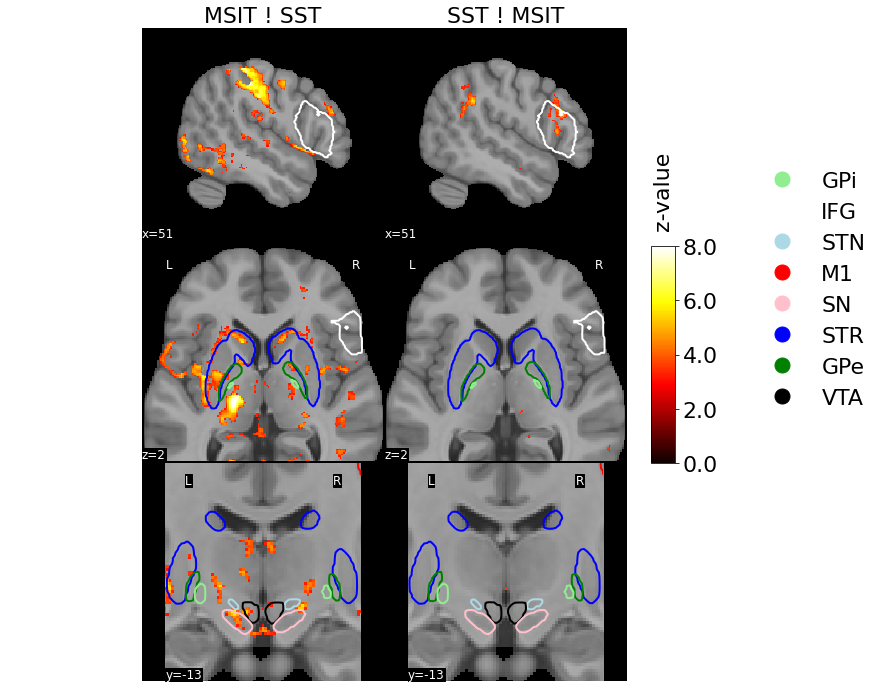

In [59]:
zmaps = [smooth_SS, smooth_INC]
mni09c = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

# plot t maps for smoothed images
fontsize = 22
vmax = 8
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, roi_dict=get_roi_dict(),z_threshold=3.1,f=f, axes=axes,roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],bg_img=mni09c,vmax=vmax, 
                          plot_columns=(0, 1, 2,3),annotate=True, empty_plots=False, skip_all_but_last=False)
axes[0,0].set_title('MSIT ! SST')
axes[0,1].set_title('SST ! MSIT')

for row in range(axes.shape[0]):
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

In [14]:
smooth_INC, smooth_SS = nilearn.image.smooth_img([subtr_INC_SS,subtr_SS_INC], fwhm=3)

Text(0.5, 1.0, 'z-value')

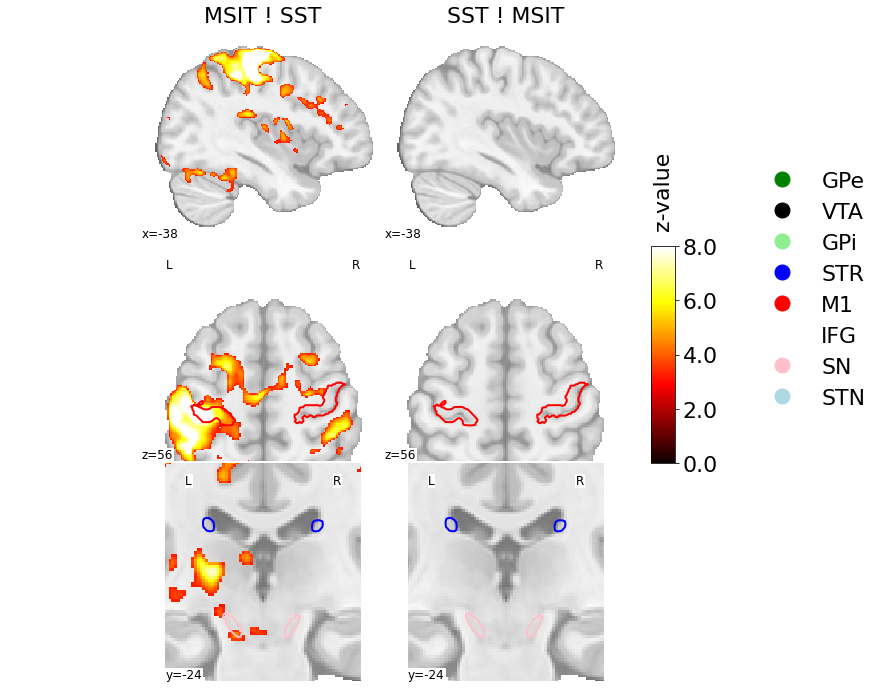

In [16]:
zmaps = [smooth_INC, smooth_SS]
mni09c = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

# plot t maps for smoothed images
fontsize = 22
vmax = 8
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, roi_dict=get_roi_dict(),z_threshold=3.1,f=f, axes=axes,roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[-38], [56], [-24]],bg_img=mni09c,vmax=vmax, 
                          plot_columns=(0, 1, 2,3),annotate=True, empty_plots=False, skip_all_but_last=False, black_bg = False)
axes[0,0].set_title('MSIT ! SST')
axes[0,1].set_title('SST ! MSIT')

for row in range(axes.shape[0]):
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

Text(0.5, 1.0, 'z-value')

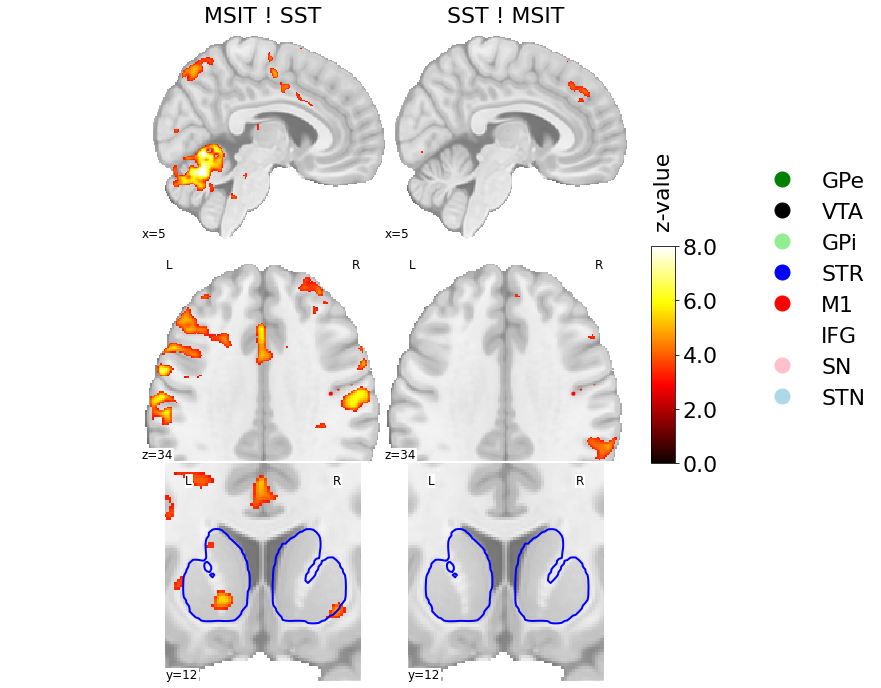

In [15]:
zmaps = [smooth_INC, smooth_SS]
mni09c = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

# plot t maps for smoothed images
fontsize = 22
vmax = 8
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, roi_dict=get_roi_dict(),z_threshold=3.1,f=f, axes=axes,roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[5], [34], [12]],bg_img=mni09c,vmax=vmax, 
                          plot_columns=(0, 1, 2,3),annotate=True, empty_plots=False, skip_all_but_last=False, black_bg=False)
axes[0,0].set_title('MSIT ! SST')
axes[0,1].set_title('SST ! MSIT')

for row in range(axes.shape[0]):
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

In [65]:
smooth_INC.to_filename('/home/scotti/projects/ntnu_fmri/test_subtr_msit_1.5mm.nii.gz')
smooth_SS.to_filename('/home/scotti/projects/ntnu_fmri/test_subtr_sst_1.5mm.nii.gz')

In [56]:
import inspect
code, line_no = inspect.getsourcelines(nilearn.image.smooth_img)
print(''.join(code))

@fill_doc
def smooth_img(imgs, fwhm):
    """Smooth images by applying a Gaussian filter.

    Apply a Gaussian filter along the three first dimensions of `arr`.
    In all cases, non-finite values in input image are replaced by zeros.

    Parameters
    ----------
    imgs : Niimg-like object or iterable of Niimg-like objects
        Image(s) to smooth (see
        http://nilearn.github.io/manipulating_images/input_output.html
        for a detailed description of the valid input types).
    %(fwhm)s

    Returns
    -------
    :class:`nibabel.nifti1.Nifti1Image` or list of
        Filtered input image. If `imgs` is an iterable, then `filtered_img` is a
        list.

    """

    # Use hasattr() instead of isinstance to workaround a Python 2.6/2.7 bug
    # See http://bugs.python.org/issue7624
    if hasattr(imgs, "__iter__") \
       and not isinstance(imgs, str):
        single_img = False
    else:
        single_img = True
        imgs = [imgs]

    ret = []
    for img in imgs

# OLD SHIT

In [72]:
from nipype.utils.filemanip import loadpkl
res = loadpkl('/home/Public/trondheim/processing/nipype_workflow_folders/feat_level12_msit_hp/_model_n_2_smoothing_fwhm_1p5_space_T1w_subject_id_042/modelestimate/result_modelestimate.pklz')
res

In [ ]:
project_folder = '/home/Public/trondheim'
work_dir = os.path.join(project_folder, 'processing', 'nipype_workflow_folders_conj')

ni_params = {'wd':work_dir,
             'sinkdir':project_folder}

l2_subdir = os.path.join(project_folder, 'derivatives/glm_feat/subject_level_model/sub-002/ses-sstmsit/func/fwhm-4p5/model-0')
con_list = ['sub-002_ses-sstmsit_task-msit_space-T1w_model-0_contrast-6', 'sub-002_ses-sstmsit_task-sst_space-T1w_model-0_contrast-3']
map_name = '_desc-zstat.nii.gz'

In [ ]:
def conj_stat_maps(map1, map2, out_file=None):
    """
    Runs a conjunction on stat maps (returning a map with the min t-stat)

    Creates a conjunction of two statistical maps (typically the result of
    EstimateContrast or Threshold from the spm interface). 
    
    Args:
        map1 (str): filename of the first stat map in the conjunction
        map2 (str): filename of the second stat map in the conjunction
        
    Optional:
        out_file (str): output filename. If None (default), creates
            'conj_map.nii' in current directory
        
    Returns:
        out_file (str): output filename (absolute path)
    
    """
    
    # Imports all required packages so the func can be run as a nipype
    # Function Node
    import nilearn.image as nli
    import os.path
    
    if (out_file is None):
        out_file = 'conj_map.nii'
        
    conj_tmap = nli.math_img('np.minimum(img1*(img1>0), img2*(img2>0)) + ' + \
                             'np.maximum(img1*(img1<0), img2*(img2<0))', 
                             img1=map1, 
                             img2=map2)
    
    conj_tmap.to_filename(out_file)
    return os.path.abspath(out_file)


In [ ]:
def conj_maps(nipype_params, l2_subdir, con_list, map_name, extent_threshold=0,
              matlab_path='', wf_name='l2_conj_fs_ic'):
    """
    Creates nipype workflow for conjuntion of statistical maps

    Args:
        nipype_params (dict): dict with the following fields:
            wd (str): path to nipype work dir
            sinkdir (str): path to datasink base dir
        l2_subdir (str): path to directory with level2 stat map outputs 
            (relative to nipype sinkdir)
        con_list (list of str): list of two contrasts to use for conjunction
            (e.g. ['con_0001', 'con_0002'])
        map_name (str): stat map name, will typically be spmT_0001.nii for
            unthresholded map and spmT_0001_thr.nii for thresholded
        
    Optional:
        extent_threshold (int): min number of voxels for cluster thresholding
            after conjunction. If 0 (default), won't run cluster thresholding.
            Should only be used when thresholded maps are provided.
        matlab_path (str): path to system matlab. Only relevant if
            extent_threshold>0
        wf_name (str): the name to use for the workflow. If None (default), 
            the workflow name will be the function name
            
    Returns:
        nipype workflow for creating a conjunction of level2 maps
    
    """
    
    # Checks whether the nipype work and base directories exists and creates
    # if they don't
    if (not os.path.exists(nipype_params['wd'])):
        os.mkdir(nipype_params['wd'])
    
    # If no workflow name was given - sets to function name    
    if (wf_name is None):
        wf_name = sys._getframe().f_code.co_name
        
    con1 = con_list[0]
    con2 = con_list[1]
    
    # selectfiles to select maps
    selectfiles = pe.Node(nio.SelectFiles({'map1': l2_subdir + f'/{con1}' + map_name,
                    'map2': l2_subdir + f'/{con2}' + map_name},
                    base_directory=nipype_params['sinkdir'], 
                    sort_filelist=True), name="selectfiles")
        
    conjmaps = pe.Node(util.Function(input_names=['map1', 'map2'], 
                output_names=['out_file'], function=conj_stat_maps),
                name='conjmaps')
        
    datasink = pe.Node(nio.DataSink(base_directory=nipype_params['sinkdir'],
                             container=''),
                    name="datasink")
    
    # Initiation of the 2nd-level analysis workflow
    wf = pe.Workflow(name=wf_name)
    wf.base_dir = nipype_params['wd']
    
    # Connect up the 2nd-level analysis components
    wf.connect([(selectfiles, conjmaps, [('map1', 'map1'), ('map2', 'map2')]),
                     (conjmaps, datasink, [('out_file','group.' + wf_name + '.@conj')])])
        
    # If a cluster threshold was provided, adds a node for cluster thresholding
    if (extent_threshold>0):
        clusterthresh = pe.Node(niu.ClusterThresh(matlab_path=matlab_path, 
                        extent_threshold=10), name='clusterthresh')
        wf.connect([(conjmaps, clusterthresh, [('out_file','in_file')]),
                     (clusterthresh, datasink, [('out_file','group.' + \
                            wf_name + '.@conj_thr'),
                    ('cluster_label_file', 'group.' + wf_name + \
                     '.@conj_label')])])
        
    return wf

In [ ]:
Intended to be run as a Node after conjunction of thresholded maps (that
already have voxel-level thresholding, assumes nan in all voxels that
do not pass threshold)

Examples
--------
>>> clusterThresh = ClusterThresh()
>>> clusterThresh.inputs.in_file = '/in_path/conj_map.nii'
>>> clusterThresh.inputs.extent_threshold = 10
>>> clusterThresh.run() 
outputs: out_file (path to output .nii file with cluster-thresholded map)

input_spec = ClusterThreshInputSpec
output_spec = ClusterThreshOutputSpec

def _run_interface(self, runtime):
    
    # Sets output files (in same dir)
    out_file = os.path.join(os.path.dirname(self.inputs.in_file),
                    self.inputs.out_fname)
    cluster_label_file = os.path.join(os.path.dirname(self.inputs.in_file),
                    'cluster_labels.nii')
    
        
    d = dict(in_file=self.inputs.in_file, out_file=out_file,
             cluster_label_file=cluster_label_file, 
             extent_threshold=self.inputs.extent_threshold,
             matlab_path=self.inputs.matlab_path)
    
    
    # Matlab code that runs the cluster thresholding, based on spm
    # Threshold interface
    script = Template("""in_file='$in_file';
                      out_file = '$out_file';
                      cluster_label_file = '$cluster_label_file';
                      matlab_path = '$matlab_path';
                      extent_threshold = $extent_threshold;
                      
                      % If matlab SPM path is given - adds it to path
                      if (~isempty(matlab_path))
                          addpath(matlab_path);
                      end
                      
                      stat_map_vol = spm_vol(in_file);
                      [stat_map_data, stat_map_XYZmm] = ...
                          spm_read_vols(stat_map_vol);
                      
                      Z = stat_map_data(:)';
                      [x,y,z] = ind2sub(size(stat_map_data), ...
                          (1:numel(stat_map_data))');
                      XYZ = cat(1, x', y', z');
                        
                      XYZth = XYZ(:, ~isnan(Z));
                      Zth = Z(~isnan(Z));
                      
                      max_size = 0;
                      max_size_index = 0;
                      th_nclusters = 0;
                      nclusters = 0;
                      if isempty(XYZth)
                          thresholded_XYZ = [];
                          thresholded_Z = [];
                      else
                          voxel_labels = spm_clusters(XYZth);
                          nclusters = max(voxel_labels);
                          
                          thresholded_XYZ = [];
                          thresholded_Z = [];
                          new_vox_labels = [];
                          
                          for i = 1:nclusters
                              cluster_size = sum(voxel_labels==i);
                              if cluster_size > extent_threshold
                                  thresholded_XYZ = cat(2, ...
                                    thresholded_XYZ, ...
                                    XYZth(:,voxel_labels == i));
                                  thresholded_Z = cat(2, ...
                                    thresholded_Z, Zth(voxel_labels == i));
                                  th_nclusters = th_nclusters + 1;
                                  new_vox_labels = cat(2, new_vox_labels,...
                                    th_nclusters*ones(1,cluster_size));
                              end
                          end
                      end
                      
                      if isempty(thresholded_XYZ)
                          thresholded_Z = [0];
                          thresholded_XYZ = [1 1 1]';
                          th_nclusters = 0;
                      end
                      
                      spm_write_filtered(thresholded_Z,thresholded_XYZ,...
                        stat_map_vol.dim',stat_map_vol.mat,...
                        'thresholded map', out_file);
                      
                      if (th_nclusters>0)
                          spm_write_filtered(new_vox_labels,...
                            thresholded_XYZ,stat_map_vol.dim',...
                            stat_map_vol.mat,'cluster_labels map',...
                            cluster_label_file);
                      end                            
                  
                      exit;
                      """).substitute(d)
                    
    mlab = MatlabCommand(script=script, mfile=True)
    result = mlab.run()
    return result.runtime

def _list_outputs(self):
    outputs = self._outputs().get()
    outputs['out_file'] = os.path.join(os.path.dirname(
            self.inputs.in_file), self.inputs.out_fname)
    outputs['cluster_label_file'] = os.path.join(os.path.dirname(
            self.inputs.in_file), 'cluster_labels.nii')
    return outputs

In [ ]:
this_workflow = conj_maps(ni_params, l2_subdir, con_list, map_name)
this_workflow.run()